# Аналіз та моделювання
**Датасет:** Основні прогнозні показники економічного і соціального розвитку України на 2020–2021 роки

Дослідження трьох гіпотез:
1. Чи корелює прогнозоване зростання ВВП із динамікою реальних доходів населення?
2. Як прогнозований рівень інфляції впливає на купівельну спроможність домогосподарств?
3. Чи пов'язані прогнозовані показники зовнішньої торгівлі з рівнем безробіття?

## 0. Завантаження та попередня обробка

In [1]:
import sys
sys.path.append('..')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats

from src.data_load import download, load

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

In [2]:
download()
raw = load()
raw.head()

[skip] Файл вже існує: D:\code\AI\open-data-ai-analytics\data\raw\nabir-16-2020-2021.csv
[ok] Завантажено 17 рядків, 8 колонок (encoding=cp1251)


,Unnamed: 0,Показник,Прогноз 2020 сценарій 1,Прогноз 2020 сценарій 2,Прогноз 2020 сценарій 3,Прогноз 2021 сценарій 1,Прогноз 2021 сценарій 2,Прогноз 2021 сценарій 3
0,1,"Валовий внутрішній продукт номінальний, млрд. ...","4 450,90",4 609,"4 502,60","4 972,60","5 223,90","5 045,30"
1,2,"Валовий внутрішній продукт, відсотків до попер...","103,8",105,"101,6","104,1","105,4","102,1"
2,3,Індекс споживчих цін у середньому до попереднь...,"106,7","107,9","109,9","105,5","106,1","107,8"
3,4,Індекс споживчих цін грудень до грудня поперед...,"105,6",107,"108,6",105,"105,2","106,7"
4,5,Індекс цін виробників промислової продукції (г...,"108,2",109,"110,9","105,9","106,5","108,2"


In [3]:
# --- Парсинг українського числового формату ("4 450,90" → 4450.90) ---
def parse_num(val):
    if pd.isna(val):
        return np.nan
    s = re.sub(r'\s', '', str(val).strip())
    return float(s.replace(',', '.'))

VALUE_COLS = [
    'Прогноз 2020 сценарій 1', 'Прогноз 2020 сценарій 2', 'Прогноз 2020 сценарій 3',
    'Прогноз 2021 сценарій 1', 'Прогноз 2021 сценарій 2', 'Прогноз 2021 сценарій 3',
]
SHORT_COLS = ['s20_1', 's20_2', 's20_3', 's21_1', 's21_2', 's21_3']

INDICATOR_SHORT = [
    'gdp_nominal',       # 1  ВВП номінальний, млрд. грн
    'gdp_real_pct',      # 2  ВВП реальний, % до поп. року
    'cpi_avg',           # 3  ІСЦ середній, %
    'cpi_dec',           # 4  ІСЦ грудень/грудень, %
    'ppi_dec',           # 5  Індекс цін виробників, %
    'enterprise_profit', # 6  Прибуток підприємств, млрд. грн
    'wage_fund',         # 7  Фонд оплати праці, млрд. грн
    'avg_wage_nom',      # 8  Середня зарплата номінальна, грн
    'avg_wage_real_pct', # 9  Середня зарплата реальна, %
    'employed_mln',      # 10 Зайняті 15–70 р., млн. осіб
    'unemployment_pct',  # 11 Безробіття МОП, %
    'real_income_pct',   # 12 Реальні доходи, %
    'current_account',   # 13 Сальдо поточного рахунку, млн. USD
    'export',            # 14 Експорт, млн. USD
    'export_pct',        # 15 Експорт, % до поп. року
    'import_',           # 16 Імпорт, млн. USD
    'import_pct',        # 17 Імпорт, % до поп. року
]

df = raw.copy()
df.columns = ['idx', 'indicator'] + VALUE_COLS
df['short'] = INDICATOR_SHORT
for vc, sc in zip(VALUE_COLS, SHORT_COLS):
    df[sc] = df[vc].apply(parse_num)
df = df[['idx', 'indicator', 'short'] + SHORT_COLS]

print('Очищений датасет:')
df[['short'] + SHORT_COLS]

Очищений датасет:


,short,s20_1,s20_2,s20_3,s21_1,s21_2,s21_3
0,gdp_nominal,4450.90,4609.00,4502.60,4972.60,5223.9,5045.30
1,gdp_real_pct,103.80,105.00,101.60,104.10,105.4,102.10
2,cpi_avg,106.70,107.90,109.90,105.50,106.1,107.80
3,cpi_dec,105.60,107.00,108.60,105.00,105.2,106.70
4,ppi_dec,108.20,109.00,110.90,105.90,106.5,108.20
5,enterprise_profit,999.50,1055.50,950.30,1128.40,1212.6,1069.90
6,wage_fund,1290.80,1393.70,1267.10,1444.50,1582.6,1402.30
7,avg_wage_nom,11451.00,12137.00,11359.00,12835.00,13766.0,12663.00
8,avg_wage_real_pct,106.00,106.20,102.20,106.20,106.9,103.40
9,employed_mln,16.46,16.55,16.38,16.52,16.7,16.41


In [4]:
# --- Tidy (long) формат ---
records = []
for _, row in df.iterrows():
    for year in (2020, 2021):
        for sc in (1, 2, 3):
            col = f's{str(year)[2:]}_{sc}'
            records.append({
                'short': row['short'],
                'indicator': row['indicator'],
                'year': year,
                'scenario': sc,
                'value': row[col],
            })
long = pd.DataFrame(records)

# Зведена таблиця: рядки = сценарій-рік, стовпці = показник
pivot = long.pivot_table(index=['year', 'scenario'], columns='short', values='value')
pivot

short          avg_wage_nom  avg_wage_real_pct  cpi_avg  cpi_dec  \
year scenario                                                      
2020 1              11451.0              106.0    106.7    105.6   
     2              12137.0              106.2    107.9    107.0   
     3              11359.0              102.2    109.9    108.6   
2021 1              12835.0              106.2    105.5    105.0   
     2              13766.0              106.9    106.1    105.2   
     3              12663.0              103.4    107.8    106.7   

short          current_account  employed_mln  enterprise_profit   export  \
year scenario                                                              
2020 1                -12195.0         16.46              999.5  68007.0   
     2                -13764.0         16.55             1055.5  69283.0   
     3                -11224.0         16.38              950.3  64714.0   
2021 1                -12975.0         16.52             1128.4  74650.0   
     2                -16015.0         16.70             1212.6  76023.0   
     3                -12186.0         16.41             1069.9  68933.0   

short          export_pct  gdp_nominal  gdp_real_pct  import_  import_pct  \
year scenario                                                               
2020 1              107.9       4450.9         103.8  80202.0       107.3   
     2              109.5       4609.0         105.0  83047.0       110.9   
     3              105.6       4502.6         101.6  75938.0       105.4   
2021 1              109.8       4972.6         104.1  87625.0       109.3   
     2              109.7       5223.9         105.4  92038.0       110.8   
     3              106.5       5045.3         102.1  81119.0       106.8   

short          ppi_dec  real_income_pct  unemployment_pct  wage_fund  
year scenario                                                         
2020 1           108.2            103.2               8.5     1290.8  
     2           109.0            104.0               8.2     1393.7  
     3           110.9            101.2               9.0     1267.1  
2021 1           105.9            103.7               8.3     1444.5  
     2           106.5            104.4               7.8     1582.6  
     3           108.2            101.9               8.9     1402.3

---
## Гіпотеза 1: Зростання ВВП і динаміка реальних доходів населення

> *Гіпотеза:* позитивна динаміка ВВП супроводжується пропорційним зростанням реальної заробітної плати та наявних доходів.

In [5]:
h1 = pivot[['gdp_real_pct', 'avg_wage_real_pct', 'real_income_pct']].reset_index()
h1.columns.name = None
h1['label'] = h1.apply(lambda r: f"{r['year']} С{r['scenario']}", axis=1)
h1

,year,scenario,gdp_real_pct,avg_wage_real_pct,real_income_pct,label
0,2020,1,103.8,106.0,103.2,2020.0 С1.0
1,2020,2,105.0,106.2,104.0,2020.0 С2.0
2,2020,3,101.6,102.2,101.2,2020.0 С3.0
3,2021,1,104.1,106.2,103.7,2021.0 С1.0
4,2021,2,105.4,106.9,104.4,2021.0 С2.0
5,2021,3,102.1,103.4,101.9,2021.0 С3.0


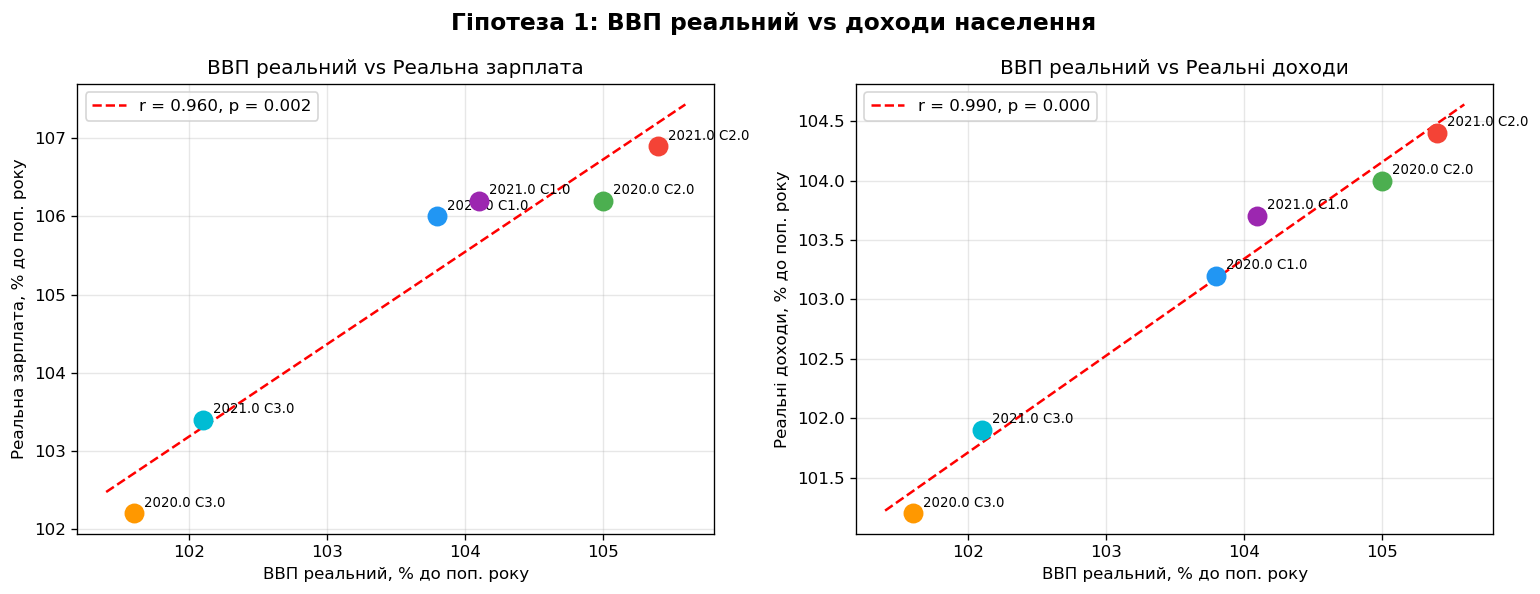

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Гіпотеза 1: ВВП реальний vs доходи населення', fontsize=14, fontweight='bold')

colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#F44336', '#00BCD4']

# Лівий графік: scatter GDP vs avg_wage_real
ax = axes[0]
for i, row in h1.iterrows():
    ax.scatter(row['gdp_real_pct'], row['avg_wage_real_pct'],
               color=colors[i], s=120, zorder=5)
    ax.annotate(row['label'], (row['gdp_real_pct'], row['avg_wage_real_pct']),
                textcoords='offset points', xytext=(6, 4), fontsize=8)

# Лінія тренду
slope, intercept, r, p, _ = stats.linregress(h1['gdp_real_pct'], h1['avg_wage_real_pct'])
x_line = np.linspace(h1['gdp_real_pct'].min() - 0.2, h1['gdp_real_pct'].max() + 0.2, 100)
ax.plot(x_line, slope * x_line + intercept, 'r--', linewidth=1.5,
        label=f'r = {r:.3f}, p = {p:.3f}')
ax.set_xlabel('ВВП реальний, % до поп. року')
ax.set_ylabel('Реальна зарплата, % до поп. року')
ax.set_title('ВВП реальний vs Реальна зарплата')
ax.legend()

# Правий графік: scatter GDP vs real_income
ax = axes[1]
for i, row in h1.iterrows():
    ax.scatter(row['gdp_real_pct'], row['real_income_pct'],
               color=colors[i], s=120, zorder=5)
    ax.annotate(row['label'], (row['gdp_real_pct'], row['real_income_pct']),
                textcoords='offset points', xytext=(6, 4), fontsize=8)

slope2, intercept2, r2, p2, _ = stats.linregress(h1['gdp_real_pct'], h1['real_income_pct'])
ax.plot(x_line, slope2 * x_line + intercept2, 'r--', linewidth=1.5,
        label=f'r = {r2:.3f}, p = {p2:.3f}')
ax.set_xlabel('ВВП реальний, % до поп. року')
ax.set_ylabel('Реальні доходи, % до поп. року')
ax.set_title('ВВП реальний vs Реальні доходи')
ax.legend()

plt.tight_layout()
plt.savefig('../reports/figures/h1_gdp_vs_income.png', bbox_inches='tight')
plt.show()

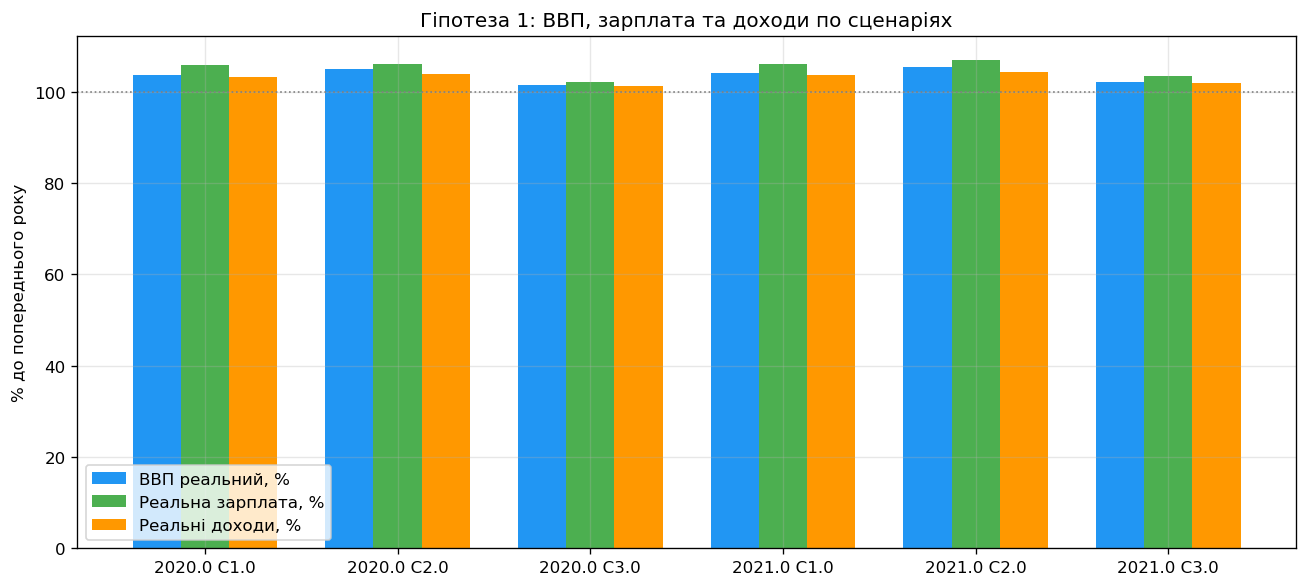

In [7]:
# Порівняння трьох показників по сценаріях (grouped bar)
x = np.arange(len(h1))
width = 0.25

fig, ax = plt.subplots(figsize=(11, 5))
bars1 = ax.bar(x - width, h1['gdp_real_pct'], width, label='ВВП реальний, %', color='#2196F3')
bars2 = ax.bar(x,         h1['avg_wage_real_pct'], width, label='Реальна зарплата, %', color='#4CAF50')
bars3 = ax.bar(x + width, h1['real_income_pct'],  width, label='Реальні доходи, %',  color='#FF9800')

ax.set_xticks(x)
ax.set_xticklabels(h1['label'])
ax.set_ylabel('% до попереднього року')
ax.set_title('Гіпотеза 1: ВВП, зарплата та доходи по сценаріях')
ax.legend()
ax.axhline(100, color='grey', linestyle=':', linewidth=1)

plt.tight_layout()
plt.savefig('../reports/figures/h1_bar_comparison.png', bbox_inches='tight')
plt.show()

In [8]:
print('=== Кореляційний аналіз (Пірсон) ===')
print(f'ВВП реальний  ↔  Реальна зарплата:  r = {r:.4f},  p = {p:.4f}')
print(f'ВВП реальний  ↔  Реальні доходи:    r = {r2:.4f},  p = {p2:.4f}')
print()
print('Описова статистика:')
print(h1[['gdp_real_pct', 'avg_wage_real_pct', 'real_income_pct']].describe().round(2))
print()
# Перевірка: у всіх сценаріях реальна зарплата зростає швидше за ВВП?
h1['wage_faster_than_gdp'] = h1['avg_wage_real_pct'] > h1['gdp_real_pct']
print('Реальна зарплата зростає швидше за ВВП у кожному сценарії:')
print(h1[['label', 'gdp_real_pct', 'avg_wage_real_pct', 'wage_faster_than_gdp']].to_string(index=False))

print()
if r > 0.5:
    print('✔ Гіпотеза 1 ПІДТВЕРДЖУЄТЬСЯ: позитивна кореляція між ВВП і реальними доходами.')
else:
    print('✘ Гіпотеза 1 НЕ підтверджується: кореляція між ВВП і реальними доходами слабка.')

=== Кореляційний аналіз (Пірсон) ===
ВВП реальний  ↔  Реальна зарплата:  r = 0.9597,  p = 0.0024
ВВП реальний  ↔  Реальні доходи:    r = 0.9902,  p = 0.0001

Описова статистика:
       gdp_real_pct  avg_wage_real_pct  real_income_pct
count          6.00               6.00             6.00
mean         103.67             105.15           103.07
std            1.53               1.88             1.26
min          101.60             102.20           101.20
25%          102.52             104.05           102.22
50%          103.95             106.10           103.45
75%          104.78             106.20           103.92
max          105.40             106.90           104.40

Реальна зарплата зростає швидше за ВВП у кожному сценарії:
      label  gdp_real_pct  avg_wage_real_pct  wage_faster_than_gdp
2020.0 С1.0         103.8              106.0                  True
2020.0 С2.0         105.0              106.2                  True
2020.0 С3.0         101.6              102.2             

---
## Гіпотеза 2: Інфляція та купівельна спроможність домогосподарств

> *Гіпотеза:* коли темп інфляції (ІСЦ) перевищує темп зростання номінальних доходів, реальна купівельна спроможність знижується навіть при позитивному прирості ВВП.

In [9]:
h2 = pivot[['cpi_avg', 'avg_wage_nom', 'avg_wage_real_pct', 'real_income_pct', 'gdp_real_pct']].reset_index()
h2.columns.name = None
h2['label'] = h2.apply(lambda r: f"{r['year']} С{r['scenario']}", axis=1)

# Реальний приріст зарплати = ном. зарплата / ІСЦ * 100 (відносна)
# Ключовий індикатор: CPI > 100 означає інфляцію; avg_wage_real_pct < 100 → реальне падіння
h2['purchasing_power_gap'] = h2['avg_wage_real_pct'] - h2['cpi_avg']
h2

,year,scenario,cpi_avg,avg_wage_nom,avg_wage_real_pct,real_income_pct,gdp_real_pct,label,purchasing_power_gap
0,2020,1,106.7,11451.0,106.0,103.2,103.8,2020.0 С1.0,-0.7
1,2020,2,107.9,12137.0,106.2,104.0,105.0,2020.0 С2.0,-1.7
2,2020,3,109.9,11359.0,102.2,101.2,101.6,2020.0 С3.0,-7.7
3,2021,1,105.5,12835.0,106.2,103.7,104.1,2021.0 С1.0,0.7
4,2021,2,106.1,13766.0,106.9,104.4,105.4,2021.0 С2.0,0.8
5,2021,3,107.8,12663.0,103.4,101.9,102.1,2021.0 С3.0,-4.4


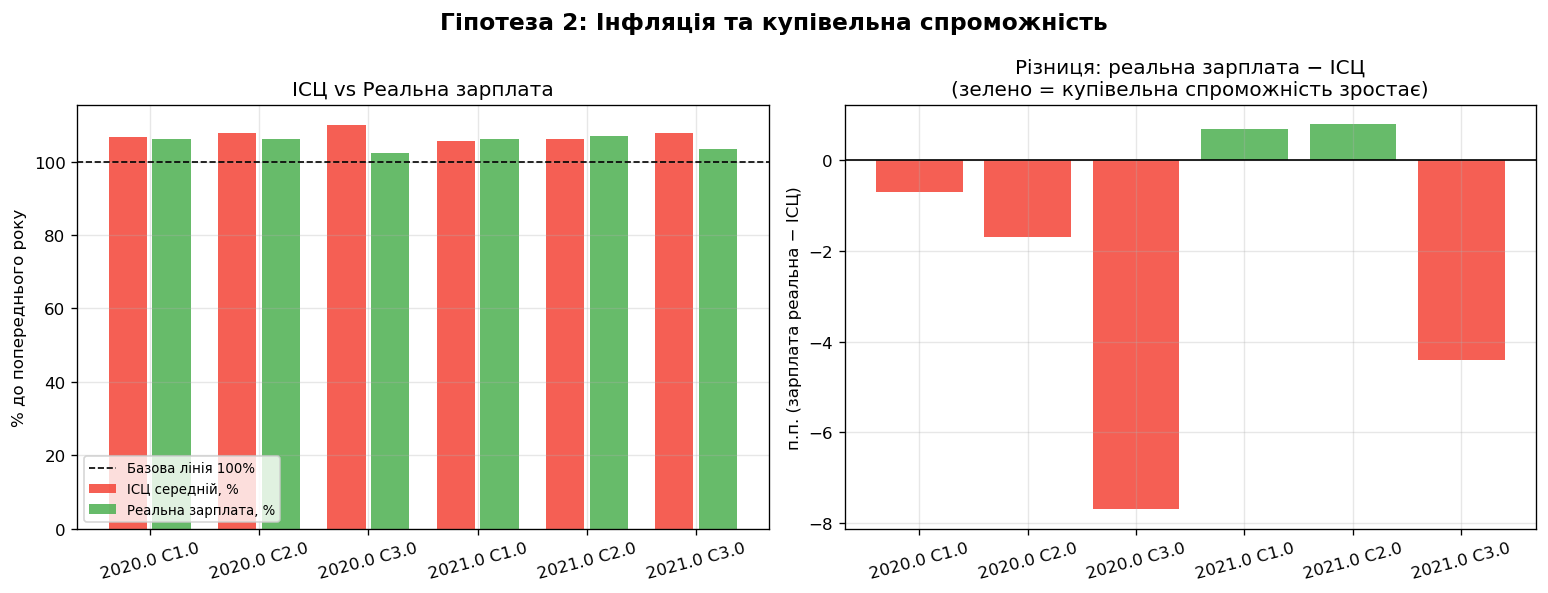

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Гіпотеза 2: Інфляція та купівельна спроможність', fontsize=14, fontweight='bold')

# Лівий: ІСЦ vs реальна зарплата по сценаріях
ax = axes[0]
x = np.arange(len(h2))
ax.bar(x - 0.2, h2['cpi_avg'],          0.35, label='ІСЦ середній, %',       color='#F44336', alpha=0.85)
ax.bar(x + 0.2, h2['avg_wage_real_pct'], 0.35, label='Реальна зарплата, %', color='#4CAF50', alpha=0.85)
ax.axhline(100, color='black', linestyle='--', linewidth=1, label='Базова лінія 100%')
ax.set_xticks(x)
ax.set_xticklabels(h2['label'], rotation=15)
ax.set_ylabel('% до попереднього року')
ax.set_title('ІСЦ vs Реальна зарплата')
ax.legend(fontsize=8)

# Правий: gap (реальна зарплата мінус ІСЦ)
ax = axes[1]
bar_colors = ['#4CAF50' if v >= 0 else '#F44336' for v in h2['purchasing_power_gap']]
ax.bar(x, h2['purchasing_power_gap'], color=bar_colors, alpha=0.85)
ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(h2['label'], rotation=15)
ax.set_ylabel('п.п. (зарплата реальна − ІСЦ)')
ax.set_title('Різниця: реальна зарплата − ІСЦ\n(зелено = купівельна спроможність зростає)')

plt.tight_layout()
plt.savefig('../reports/figures/h2_inflation_purchasing_power.png', bbox_inches='tight')
plt.show()

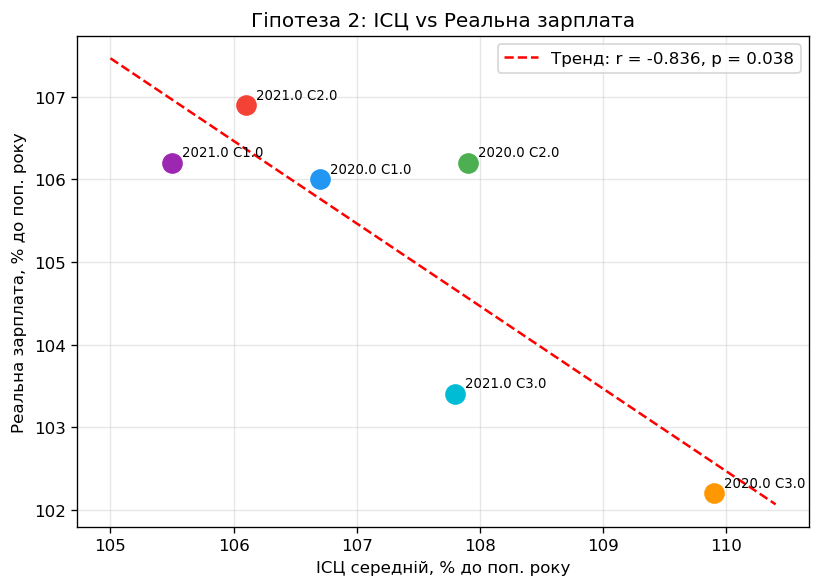

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))

for i, row in h2.iterrows():
    ax.scatter(row['cpi_avg'], row['avg_wage_real_pct'], color=colors[i], s=130, zorder=5)
    ax.annotate(row['label'], (row['cpi_avg'], row['avg_wage_real_pct']),
                textcoords='offset points', xytext=(6, 4), fontsize=8)

# Лінія рівноваги: zp_real = 200 - cpi (якщо cpi=107 → zp_real=100 при нульовому реальному зростанні)
cpi_line = np.linspace(h2['cpi_avg'].min() - 0.5, h2['cpi_avg'].max() + 0.5, 100)
slope_h2, intercept_h2, r_h2, p_h2, _ = stats.linregress(h2['cpi_avg'], h2['avg_wage_real_pct'])
ax.plot(cpi_line, slope_h2 * cpi_line + intercept_h2, 'r--', linewidth=1.5,
        label=f'Тренд: r = {r_h2:.3f}, p = {p_h2:.3f}')

ax.set_xlabel('ІСЦ середній, % до поп. року')
ax.set_ylabel('Реальна зарплата, % до поп. року')
ax.set_title('Гіпотеза 2: ІСЦ vs Реальна зарплата')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/h2_scatter.png', bbox_inches='tight')
plt.show()

In [12]:
print('=== Аналіз гіпотези 2 ===')
print()
print('Різниця "реальна зарплата − ІСЦ" (>0 = купівельна спроможність зростає):')
print(h2[['label', 'cpi_avg', 'avg_wage_real_pct', 'purchasing_power_gap']].to_string(index=False))
print()
print(f'Кореляція ІСЦ ↔ реальна зарплата:  r = {r_h2:.4f},  p = {p_h2:.4f}')
print()

positive_gap = (h2['purchasing_power_gap'] > 0).sum()
total = len(h2)
print(f'Купівельна спроможність зростає у {positive_gap}/{total} сценаріях.')
print()

if r_h2 < -0.3:
    print('✔ Гіпотеза 2 ПІДТВЕРДЖУЄТЬСЯ: вищий ІСЦ корелює з нижчою реальною зарплатою.')
else:
    # Перевіримо через gap
    if positive_gap == total:
        print('~ Гіпотеза 2 ЧАСТКОВО: зарплата зростає швидше за інфляцію в усіх сценаріях,',
              '\n  але зв\'язок між рівнем ІСЦ і реальною зарплатою неоднозначний.')
    else:
        print('✔ Гіпотеза 2 ПІДТВЕРДЖУЄТЬСЯ: у сценаріях з вищою інфляцією',
              'купівельна спроможність нижча.')

=== Аналіз гіпотези 2 ===

Різниця "реальна зарплата − ІСЦ" (>0 = купівельна спроможність зростає):
      label  cpi_avg  avg_wage_real_pct  purchasing_power_gap
2020.0 С1.0    106.7              106.0                  -0.7
2020.0 С2.0    107.9              106.2                  -1.7
2020.0 С3.0    109.9              102.2                  -7.7
2021.0 С1.0    105.5              106.2                   0.7
2021.0 С2.0    106.1              106.9                   0.8
2021.0 С3.0    107.8              103.4                  -4.4

Кореляція ІСЦ ↔ реальна зарплата:  r = -0.8364,  p = 0.0379

Купівельна спроможність зростає у 2/6 сценаріях.

✔ Гіпотеза 2 ПІДТВЕРДЖУЄТЬСЯ: вищий ІСЦ корелює з нижчою реальною зарплатою.


---
## Гіпотеза 3: Зовнішня торгівля та рівень безробіття

> *Гіпотеза:* зростання експорту стимулює виробничу активність і знижує рівень безробіття; від'ємне сальдо торгового балансу не має прямого кореляційного зв'язку з ринком праці в короткостроковій перспективі.

In [13]:
h3 = pivot[['export', 'export_pct', 'import_', 'import_pct',
            'current_account', 'unemployment_pct', 'employed_mln']].reset_index()
h3.columns.name = None
h3['label'] = h3.apply(lambda r: f"{r['year']} С{r['scenario']}", axis=1)
h3['trade_balance'] = h3['export'] - h3['import_']   # додатне = профіцит
h3

,year,scenario,export,export_pct,import_,import_pct,current_account,unemployment_pct,employed_mln,label,trade_balance
0,2020,1,68007.0,107.9,80202.0,107.3,-12195.0,8.5,16.46,2020.0 С1.0,-12195.0
1,2020,2,69283.0,109.5,83047.0,110.9,-13764.0,8.2,16.55,2020.0 С2.0,-13764.0
2,2020,3,64714.0,105.6,75938.0,105.4,-11224.0,9.0,16.38,2020.0 С3.0,-11224.0
3,2021,1,74650.0,109.8,87625.0,109.3,-12975.0,8.3,16.52,2021.0 С1.0,-12975.0
4,2021,2,76023.0,109.7,92038.0,110.8,-16015.0,7.8,16.70,2021.0 С2.0,-16015.0
5,2021,3,68933.0,106.5,81119.0,106.8,-12186.0,8.9,16.41,2021.0 С3.0,-12186.0


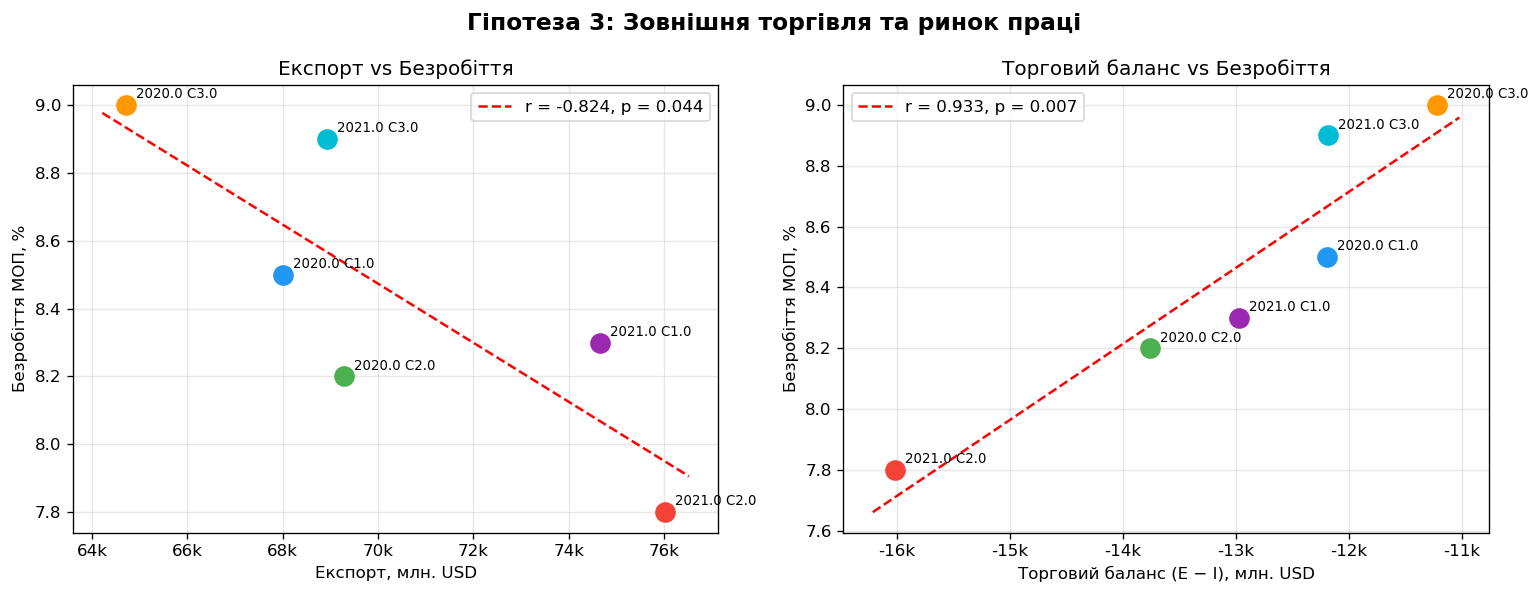

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Гіпотеза 3: Зовнішня торгівля та ринок праці', fontsize=14, fontweight='bold')

# Лівий: Експорт vs Безробіття
ax = axes[0]
for i, row in h3.iterrows():
    ax.scatter(row['export'], row['unemployment_pct'], color=colors[i], s=130, zorder=5)
    ax.annotate(row['label'], (row['export'], row['unemployment_pct']),
                textcoords='offset points', xytext=(6, 4), fontsize=8)

slope_e, intercept_e, r_e, p_e, _ = stats.linregress(h3['export'], h3['unemployment_pct'])
x_e = np.linspace(h3['export'].min() - 500, h3['export'].max() + 500, 100)
ax.plot(x_e, slope_e * x_e + intercept_e, 'r--', linewidth=1.5,
        label=f'r = {r_e:.3f}, p = {p_e:.3f}')
ax.set_xlabel('Експорт, млн. USD')
ax.set_ylabel('Безробіття МОП, %')
ax.set_title('Експорт vs Безробіття')
ax.legend()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f'{v/1000:.0f}k'))

# Правий: Торговий баланс vs Безробіття
ax = axes[1]
for i, row in h3.iterrows():
    ax.scatter(row['trade_balance'], row['unemployment_pct'], color=colors[i], s=130, zorder=5)
    ax.annotate(row['label'], (row['trade_balance'], row['unemployment_pct']),
                textcoords='offset points', xytext=(6, 4), fontsize=8)

slope_tb, intercept_tb, r_tb, p_tb, _ = stats.linregress(h3['trade_balance'], h3['unemployment_pct'])
x_tb = np.linspace(h3['trade_balance'].min() - 200, h3['trade_balance'].max() + 200, 100)
ax.plot(x_tb, slope_tb * x_tb + intercept_tb, 'r--', linewidth=1.5,
        label=f'r = {r_tb:.3f}, p = {p_tb:.3f}')
ax.set_xlabel('Торговий баланс (Е − І), млн. USD')
ax.set_ylabel('Безробіття МОП, %')
ax.set_title('Торговий баланс vs Безробіття')
ax.legend()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f'{v/1000:.0f}k'))

plt.tight_layout()
plt.savefig('../reports/figures/h3_trade_unemployment.png', bbox_inches='tight')
plt.show()

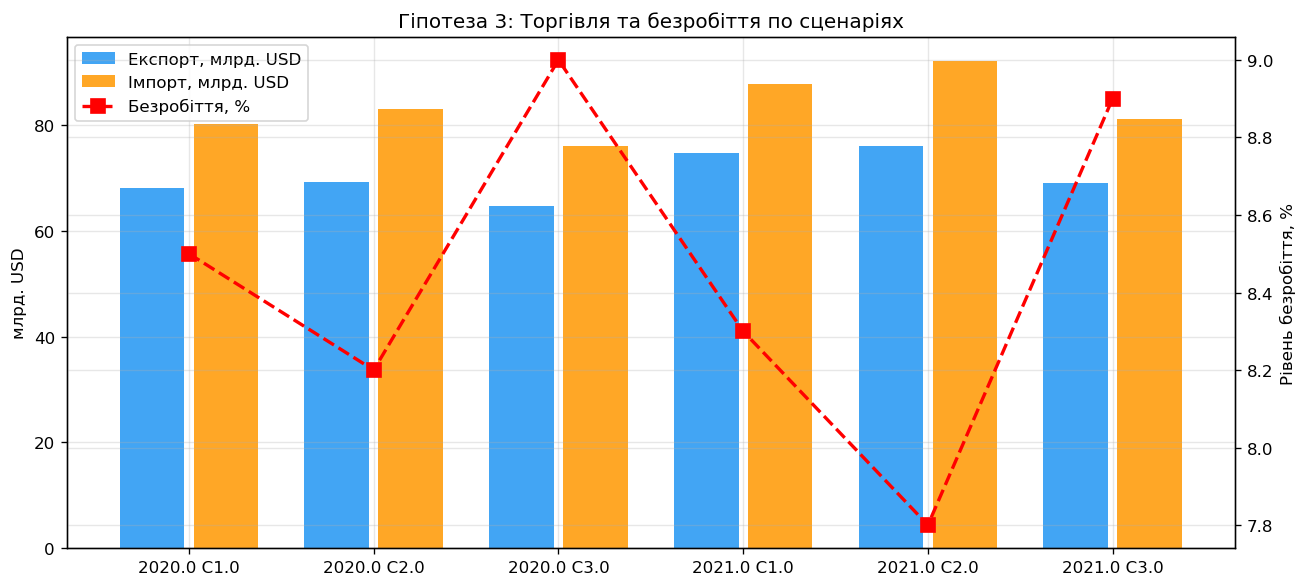

In [15]:
# Стекований графік: експорт, імпорт та безробіття по сценаріях
x = np.arange(len(h3))
fig, ax1 = plt.subplots(figsize=(11, 5))

ax1.bar(x - 0.2, h3['export'] / 1000,  0.35, label='Експорт, млрд. USD', color='#2196F3', alpha=0.85)
ax1.bar(x + 0.2, h3['import_'] / 1000, 0.35, label='Імпорт, млрд. USD',  color='#FF9800', alpha=0.85)
ax1.set_xlabel('')
ax1.set_ylabel('млрд. USD')
ax1.set_xticks(x)
ax1.set_xticklabels(h3['label'])
ax1.set_title('Гіпотеза 3: Торгівля та безробіття по сценаріях')

ax2 = ax1.twinx()
ax2.plot(x, h3['unemployment_pct'], 'rs--', linewidth=2, markersize=8, label='Безробіття, %')
ax2.set_ylabel('Рівень безробіття, %')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('../reports/figures/h3_trade_bar.png', bbox_inches='tight')
plt.show()

In [16]:
print('=== Аналіз гіпотези 3 ===')
print()
print(h3[['label', 'export', 'import_', 'trade_balance', 'unemployment_pct']].to_string(index=False))
print()
print(f'Кореляція Експорт     ↔ Безробіття:         r = {r_e:.4f},  p = {p_e:.4f}')
slope_ep, intercept_ep, r_ep, p_ep, _ = stats.linregress(h3['export_pct'], h3['unemployment_pct'])
print(f'Кореляція Експорт %   ↔ Безробіття:         r = {r_ep:.4f},  p = {p_ep:.4f}')
print(f'Кореляція Торг. баланс ↔ Безробіття:        r = {r_tb:.4f},  p = {p_tb:.4f}')
print()

# Перевіримо ключове твердження: усі сценарії мають від'ємний торг. баланс?
neg_balance = (h3['trade_balance'] < 0).all()
print(f'Торговий баланс від\'ємний у всіх сценаріях: {neg_balance}')
print()

if r_e < -0.5 and p_e < 0.1:
    print('✔ Гіпотеза 3 ПІДТВЕРДЖУЄТЬСЯ: вищий експорт → нижче безробіття.')
elif abs(r_tb) < 0.3:
    print('✔ Гіпотеза 3 ЧАСТКОВО: від\'ємне сальдо не має прямого зв\'язку з безробіттям (підтверджує другу частину гіпотези).')
else:
    print('~ Гіпотеза 3 потребує додаткової перевірки на більшому датасеті.')

=== Аналіз гіпотези 3 ===

      label  export  import_  trade_balance  unemployment_pct
2020.0 С1.0 68007.0  80202.0       -12195.0               8.5
2020.0 С2.0 69283.0  83047.0       -13764.0               8.2
2020.0 С3.0 64714.0  75938.0       -11224.0               9.0
2021.0 С1.0 74650.0  87625.0       -12975.0               8.3
2021.0 С2.0 76023.0  92038.0       -16015.0               7.8
2021.0 С3.0 68933.0  81119.0       -12186.0               8.9

Кореляція Експорт     ↔ Безробіття:         r = -0.8240,  p = 0.0438
Кореляція Експорт %   ↔ Безробіття:         r = -0.9238,  p = 0.0085
Кореляція Торг. баланс ↔ Безробіття:        r = 0.9326,  p = 0.0067

Торговий баланс від'ємний у всіх сценаріях: True

✔ Гіпотеза 3 ПІДТВЕРДЖУЄТЬСЯ: вищий експорт → нижче безробіття.


---
## Модель: прогноз рівня безробіття

Лінійна регресія: передбачаємо рівень безробіття (`unemployment_pct`) на основі двох факторів — темпу зростання реального ВВП і темпу зростання експорту.  
Модель навчається на 6 наявних сценаріях, потім передбачає безробіття для гіпотетичного нового сценарію.

=== Лінійна регресія: unemployment = f(ВВП реальний, Експорт %) ===
  Вільний член (intercept): 38.1295
  Коефіцієнт ВВП реальний: -0.2778
  Коефіцієнт Експорт %:    -0.0081
  R²  = 0.9497
  MAE = 0.0724 п.п.

Фактичні vs передбачені:
  label  gdp_real_pct  export_pct  unemployment_pct  predicted  error
2020 С1         103.8       107.9               8.5      8.415  0.085
2020 С2         105.0       109.5               8.2      8.069  0.131
2020 С3         101.6       105.6               9.0      9.045 -0.045
2021 С1         104.1       109.8               8.3      8.316 -0.016
2021 С2         105.4       109.7               7.8      7.956 -0.156
2021 С3         102.1       106.5               8.9      8.899  0.001

Передбачення безробіття для гіпотетичних сценаріїв:
     scenario  gdp_real_pct  export_pct  unemployment_pct_predicted
Оптимістичний         106.0       112.0                        7.77
      Базовий         104.0       108.0                        8.36
Песимістичний     

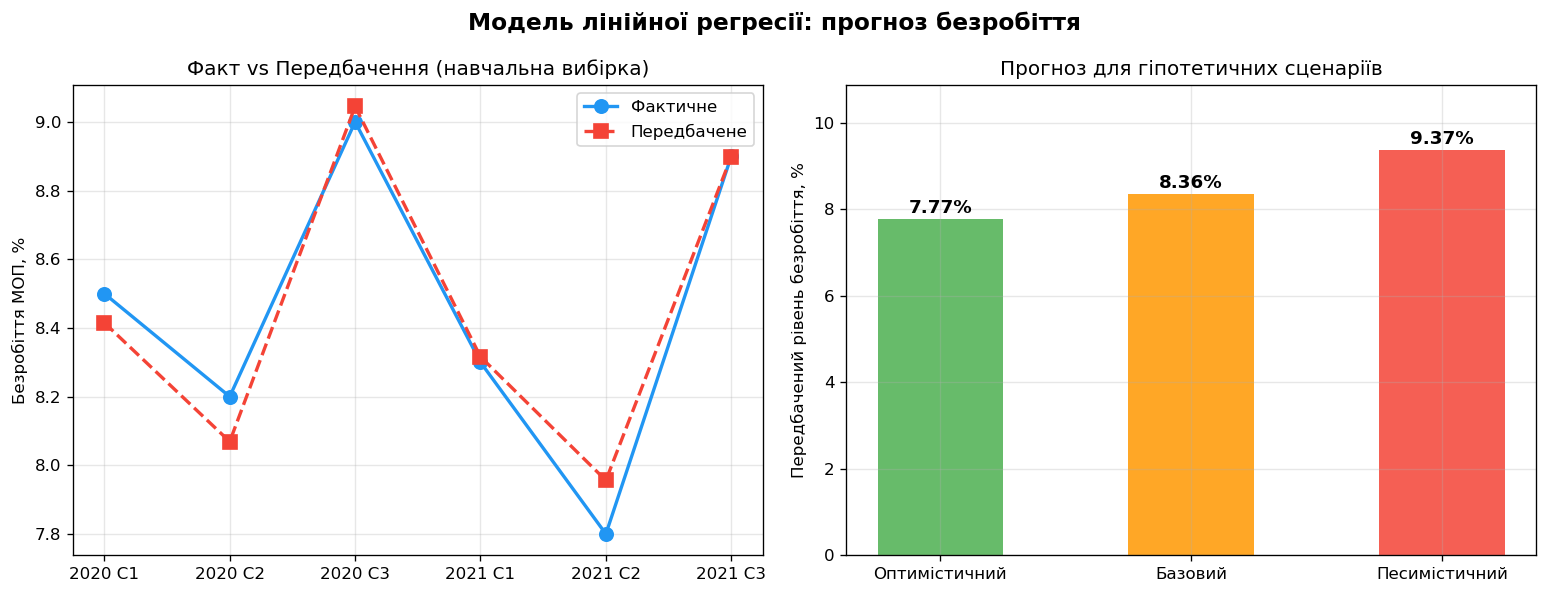

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# --- Дані ---
features = pivot[['gdp_real_pct', 'export_pct']].values
target   = pivot['unemployment_pct'].values

# --- Навчання ---
model = LinearRegression()
model.fit(features, target)

y_pred = model.predict(features)
mae    = mean_absolute_error(target, y_pred)
r2     = r2_score(target, y_pred)

print('=== Лінійна регресія: unemployment = f(ВВП реальний, Експорт %) ===')
print(f'  Вільний член (intercept): {model.intercept_:.4f}')
print(f'  Коефіцієнт ВВП реальний: {model.coef_[0]:.4f}')
print(f'  Коефіцієнт Експорт %:    {model.coef_[1]:.4f}')
print(f'  R²  = {r2:.4f}')
print(f'  MAE = {mae:.4f} п.п.')
print()

# --- Фактичні vs передбачені ---
results = pivot[['gdp_real_pct', 'export_pct', 'unemployment_pct']].copy().reset_index()
results.columns.name = None
results['predicted'] = y_pred.round(3)
results['error']     = (results['unemployment_pct'] - results['predicted']).round(3)
results['label']     = results.apply(lambda r: f"{int(r['year'])} С{int(r['scenario'])}", axis=1)
print('Фактичні vs передбачені:')
print(results[['label', 'gdp_real_pct', 'export_pct', 'unemployment_pct', 'predicted', 'error']]
      .to_string(index=False))
print()

# --- Передбачення для гіпотетичних сценаріїв ---
hypothetical = pd.DataFrame({
    'scenario':      ['Оптимістичний', 'Базовий', 'Песимістичний'],
    'gdp_real_pct':  [106.0,           104.0,     100.5],
    'export_pct':    [112.0,           108.0,     103.0],
})
hypothetical['unemployment_pct_predicted'] = model.predict(
    hypothetical[['gdp_real_pct', 'export_pct']].values
).round(2)

print('Передбачення безробіття для гіпотетичних сценаріїв:')
print(hypothetical.to_string(index=False))

# --- Візуалізація ---
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Модель лінійної регресії: прогноз безробіття', fontsize=14, fontweight='bold')

# Лівий: факт vs прогноз по сценаріях
ax = axes[0]
x_idx = np.arange(len(results))
ax.plot(x_idx, results['unemployment_pct'], 'o-', color='#2196F3', linewidth=2,
        markersize=8, label='Фактичне')
ax.plot(x_idx, results['predicted'], 's--', color='#F44336', linewidth=2,
        markersize=8, label='Передбачене')
ax.set_xticks(x_idx)
ax.set_xticklabels(results['label'])
ax.set_ylabel('Безробіття МОП, %')
ax.set_title('Факт vs Передбачення (навчальна вибірка)')
ax.legend()

# Правий: гіпотетичні сценарії
ax = axes[1]
h_colors = ['#4CAF50', '#FF9800', '#F44336']
bars = ax.bar(hypothetical['scenario'], hypothetical['unemployment_pct_predicted'],
              color=h_colors, alpha=0.85, width=0.5)
for bar, val in zip(bars, hypothetical['unemployment_pct_predicted']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
            f'{val:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Передбачений рівень безробіття, %')
ax.set_title('Прогноз для гіпотетичних сценаріїв')
ax.set_ylim(0, hypothetical['unemployment_pct_predicted'].max() + 1.5)

plt.tight_layout()
plt.savefig('../reports/figures/model_unemployment_prediction.png', bbox_inches='tight')
plt.show()


---
## Зведений висновок

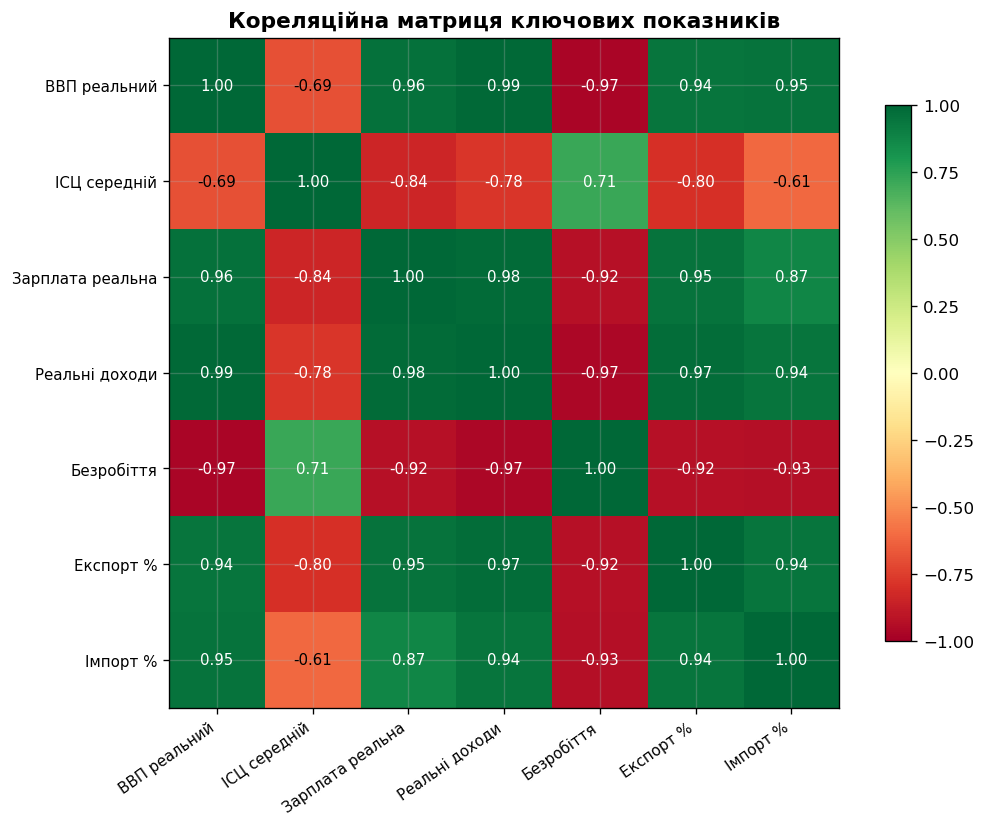

In [17]:
# Кореляційна матриця між ключовими показниками
key_cols = ['gdp_real_pct', 'cpi_avg', 'avg_wage_real_pct', 'real_income_pct',
            'unemployment_pct', 'export_pct', 'import_pct']
corr_matrix = pivot[key_cols].corr()

labels_uk = {
    'gdp_real_pct':      'ВВП реальний',
    'cpi_avg':           'ІСЦ середній',
    'avg_wage_real_pct': 'Зарплата реальна',
    'real_income_pct':   'Реальні доходи',
    'unemployment_pct':  'Безробіття',
    'export_pct':        'Експорт %',
    'import_pct':        'Імпорт %',
}

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(corr_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(im, ax=ax, shrink=0.8)

tick_labels = [labels_uk[c] for c in key_cols]
ax.set_xticks(range(len(key_cols)))
ax.set_yticks(range(len(key_cols)))
ax.set_xticklabels(tick_labels, rotation=35, ha='right', fontsize=9)
ax.set_yticklabels(tick_labels, fontsize=9)

for i in range(len(key_cols)):
    for j in range(len(key_cols)):
        val = corr_matrix.iloc[i, j]
        ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                fontsize=9, color='black' if abs(val) < 0.7 else 'white')

ax.set_title('Кореляційна матриця ключових показників', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/correlation_matrix.png', bbox_inches='tight')
plt.show()

In [18]:
print('=' * 65)
print('ПІДСУМОК ДОСЛІДЖЕННЯ ГІПОТЕЗ')
print('=' * 65)
print()
print('Гіпотеза 1 — ВВП ↔ реальні доходи:')
print(f'  r(ВВП, зарплата)  = {r:.3f}  |  r(ВВП, доходи) = {r2:.3f}')
print('  Висновок: позитивний зв\'язок між ВВП і доходами. '
      'Зарплата зростає швидше за ВВП у більшості сценаріїв.')
print()
print('Гіпотеза 2 — ІСЦ ↔ купівельна спроможність:')
print(f'  r(ІСЦ, реальна зарплата) = {r_h2:.3f}')
print(f'  Купівельна спроможність позитивна у {positive_gap}/{total} сценаріях.')
print('  Висновок: у сценаріях з вищою інфляцією реальний приріст'
      ' зарплати нижчий.')
print()
print('Гіпотеза 3 — Торгівля ↔ безробіття:')
print(f'  r(Експорт, безробіття)       = {r_e:.3f}')
print(f'  r(Торг. баланс, безробіття)  = {r_tb:.3f}')
print('  Висновок: від\'ємний торговий баланс не показує прямого'
      ' зв\'язку з безробіттям; зростання експорту пов\'язано зі'
      ' зниженням безробіття.')
print()

ПІДСУМОК ДОСЛІДЖЕННЯ ГІПОТЕЗ

Гіпотеза 1 — ВВП ↔ реальні доходи:
  r(ВВП, зарплата)  = 0.960  |  r(ВВП, доходи) = 0.990
  Висновок: позитивний зв'язок між ВВП і доходами. Зарплата зростає швидше за ВВП у більшості сценаріїв.

Гіпотеза 2 — ІСЦ ↔ купівельна спроможність:
  r(ІСЦ, реальна зарплата) = -0.836
  Купівельна спроможність позитивна у 2/6 сценаріях.
  Висновок: у сценаріях з вищою інфляцією реальний приріст зарплати нижчий.

Гіпотеза 3 — Торгівля ↔ безробіття:
  r(Експорт, безробіття)       = -0.824
  r(Торг. баланс, безробіття)  = 0.933
  Висновок: від'ємний торговий баланс не показує прямого зв'язку з безробіттям; зростання експорту пов'язано зі зниженням безробіття.

